In [16]:
from Clough_Toucher_derivation import *
import igl
import meshio as mio
import numpy as np

In [71]:
def f1(x, y):
    return x

def d1(x, y):
    return np.array([1, 0])

def f2(x, y):
    return x ** 2

def d2(x, y):
    return np.array([2 * x, 0])


In [31]:
v, uv, _, f, f_uv, _ = igl.read_obj("test_two_triangles.obj")

In [32]:
uv

array([[0., 0.],
       [1., 0.],
       [1., 1.],
       [2., 1.]])

In [82]:
def build_boundary_data(f, d):
    boundary_data = []

    for fid in range(f_uv.shape[0]):
        fv = f_uv[fid]
        v0 = uv[fv[0]]
        v1 = uv[fv[1]]
        v2 = uv[fv[2]]
        m0 = (v0 + v1) / 2.0
        m1 = (v1 + v2) / 2.0
        m2 = (v2 + v0) / 2.0

        e01 = v1 - v0
        e12 = v2 - v1
        e20 = v0 - v2

        em0 = v2 - m0
        em1 = v0 - m1
        em2 = v1 - m2

        f0 = f(v0[0], v0[1])
        f1 = f(v1[0], v1[1])
        f2 = f(v2[0], v2[1])
        # print (f0)

        d0 = d(v0[0], v0[1])
        d1 = d(v1[0], v1[1])
        d2 = d(v2[0], v2[1])
        # print(d0)
        
        dm0 = d(m0[0], m0[1])
        dm1 = d(m1[0], m1[1])
        dm2 = d(m2[0], m2[1])

        d01 = d0 @ e01
        d10 = d1 @ (-e01)
        d12 = d1 @ e12
        d21 = d2 @ (-e12)
        d20 = d2 @ e20
        d02 = d0 @ (-e20)

        dm01 = dm0 @ em0
        dm12 = dm1 @ em1
        dm20 = dm2 @ em2

        bd = [f0,f1,f2, d01, d10, d12, d21, d20, d02, dm01, dm12, dm20]
        boundary_data.append(bd)

    return boundary_data

In [51]:
f1_bd = build_boundary_data(f1, d1)

with open("../../build/f1_boundary_data.txt", "w") as file:
    for line in f1_bd:
        for value in line:
            file.write("{} ".format(value))
        file.write("\n")

In [133]:
ct_interpolants = []
with open("../../build/two_tri_f1_function_values_from_lagrange_nodes.txt", "r") as file:
    for line in file:
        value = float(line.split()[0])
        ct_interpolants.append(value)
ct_interpolants = np.array(ct_interpolants)

ct_interpolants_uvs = []
with open("../../build/two_tri_f1_function_values_from_lagrange_nodes_uvs.txt", "r") as file:
    for line in file:
        s = line.split()
        ct_interpolants_uvs.append([float(s[0]), float(s[1])])
ct_interpolants_uvs = np.array(ct_interpolants_uvs)

interior_matix = np.loadtxt('../../build/two_tri_f1_interior_constraint_matrix.txt') 
edge_end_point_matrix = np.loadtxt('../../build/two_tri_f1_edge_endpoint_constraint_matrix.txt') 
edge_mid_point_matrix = np.loadtxt('../../build/two_tri_f1_edge_midpoint_constraint_matrix.txt') 

r1 = interior_matix @ ct_interpolants
r2 = edge_end_point_matrix @ ct_interpolants
r3 = edge_mid_point_matrix @ ct_interpolants

print("interior constraint max: ", np.max(np.abs(r1)))
print("interior constraint avg: ", np.average(np.abs(r1)))
print("edge endpoint constraint max: ", np.max(np.abs(r2)))
print("edge endpoint constraint avg: ", np.average(np.abs(r2)))
print("edge midpoint constraint max: ", np.max(np.abs(r3)))
print("edge midpoint constraint avg: ", np.average(np.abs(r3)))


interior constraint max:  1.5543122344752192e-15
interior constraint avg:  4.004733053112172e-16
edge endpoint constraint max:  3.552713678800501e-15
edge endpoint constraint avg:  5.329070518200751e-16
edge midpoint constraint max:  0.0
edge midpoint constraint avg:  0.0


In [134]:
r3

array([0., 0., 0., 0., 0.])

[0.         1.         1.         2.         0.33333333 0.66666667
 1.         1.         0.66666667 0.33333333 0.55555556 0.88888889
 0.55555556 0.22222222 0.44444444 0.88888889 0.77777778 0.88888889
 0.77777778 0.66666667 1.33333333 1.66666667 1.66666667 1.33333333
 1.44444444 1.44444444 1.11111111 1.11111111 1.22222222 1.77777778
 1.55555556 1.11111111 1.22222222 1.33333333]
[0.       1.       1.       2.       0.333333 0.666667 1.       1.
 0.666667 0.333333 0.555556 0.888889 0.555556 0.222222 0.444444 0.888889
 0.777778 0.888889 0.777778 0.666667 1.33333  1.66667  1.66667  1.33333
 1.44444  1.44444  1.11111  1.11111  1.22222  1.77778  1.55556  1.11111
 1.22222  1.33333 ]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.33333333e-07  3.33333333e-07  0.00000000e+00  0.00000000e+00
  3.33333333e-07 -3.33333333e-07  4.44444444e-07  1.11111111e-07
  4.44444444e-07 -2.22222222e-07 -4.44444444e-07  1.11111111e-07
  2.22222222e-07  1.11111112e-07  2.22222222e-07  3.333

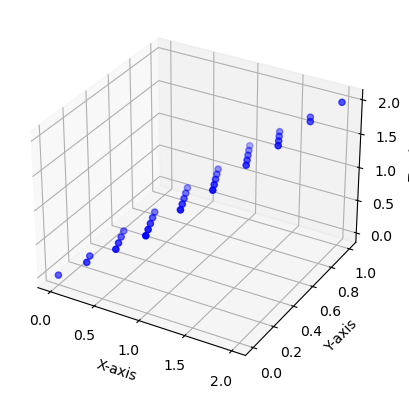

In [113]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Create a grid of x and y values
X = ct_interpolants_uvs[:, 0]
Y = ct_interpolants_uvs[:, 1]

# get interpolants
Z = ct_interpolants

# compute real function values
Z_real = []
for i in range(X.shape[0]):
    Z_real.append(f1(X[i], Y[i]))
Z_real = np.array(Z_real)
print(Z)
print(Z_real)
print(Z_real - ct_interpolants)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the values
ax.scatter(X, Y, Z, c = 'b', marker='o')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

plt.show()

In [85]:
f2_bd = build_boundary_data(f2, d2)

with open("../../build/f2_boundary_data.txt", "w") as file:
    for line in f2_bd:
        for value in line:
            file.write("{} ".format(value))
        file.write("\n")

In [84]:
f2_bd

[[0.0, 1.0, 1.0, 0.0, -2.0, 0.0, 0.0, -2.0, 0.0, 0.5, -2.0, 0.5],
 [1.0, 4.0, 1.0, 2.0, -4.0, -4.0, 2.0, 0.0, 0.0, -1.5, -1.5, 2.0]]

In [140]:
ct_interpolants = []
with open("../../build/two_tri_f2_function_values_from_lagrange_nodes.txt", "r") as file:
    for line in file:
        value = float(line.split()[0])
        ct_interpolants.append(value)
ct_interpolants = np.array(ct_interpolants)

interior_matix = np.loadtxt('../../build/two_tri_f2_interior_constraint_matrix.txt') 
edge_end_point_matrix = np.loadtxt('../../build/two_tri_f2_edge_endpoint_constraint_matrix.txt') 
edge_mid_point_matrix = np.loadtxt('../../build/two_tri_f2_edge_midpoint_constraint_matrix.txt')

r1 = interior_matix @ ct_interpolants
r2 = edge_end_point_matrix @ ct_interpolants
r3 = edge_mid_point_matrix @ ct_interpolants

print("interior constraint max: ", np.max(np.abs(r1)))
print("interior constraint avg: ", np.average(np.abs(r1)))
print("edge endpoint constraint max: ", np.max(np.abs(r2)))
print("edge endpoint constraint avg: ", np.average(np.abs(r2)))
print("edge midpoint constraint max: ", np.max(np.abs(r3)))
print("edge midpoint constraint avg: ", np.average(np.abs(r3)))



interior constraint max:  1.3322676295501878e-15
interior constraint avg:  4.292201514845471e-16
edge endpoint constraint max:  3.552713678800501e-15
edge endpoint constraint avg:  3.552713678800501e-16
edge midpoint constraint max:  3.552713678800501e-15
edge midpoint constraint avg:  7.105427357601002e-16


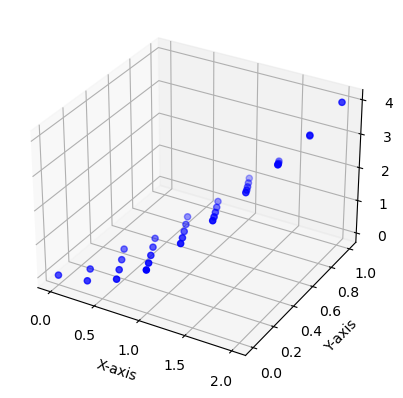

In [120]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Create a grid of x and y values
X = ct_interpolants_uvs[:, 0]
Y = ct_interpolants_uvs[:, 1]

# get interpolants
Z = ct_interpolants

# compute real function values
Z_real = []
for i in range(X.shape[0]):
    Z_real.append(f2(X[i], Y[i]))
Z_real = np.array(Z_real)
# print(Z)
# print(Z_real)
# print(Z_real - ct_interpolants)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the values
ax.scatter(X, Y, Z_real, c = 'b', marker='o')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

plt.show()

In [98]:
r3

array([ 0.,  0.,  0., -1.,  0.])

In [90]:
r3

array([0., 0., 0., 5., 0.])

In [103]:
x = np.linspace(-6, 6, 2)
y = np.linspace(-6, 6, 2)
X, Y = np.meshgrid(x, y)

In [106]:
x

array([-6.,  6.])